In [ ]:
print("=== David Li's Multivariate Copula Model Analysis ===\n")

=== David Li's Multivariate Copula Model Analysis ===



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
class MultivariateCopulaModel:
    """
    Implementation of David Li's multivariate copula model for financial applications
    Using t-copula with 2 degrees of freedom
    """
    
    def __init__(self, df=2):
        self.df = df  # degrees of freedom
        self.correlation_matrix = None
        self.marginal_distributions = {}
        
    def fit_marginals(self, data, distribution='normal'):
        """Fit marginal distributions to each asset"""
        n_assets = data.shape[1]
        self.marginal_distributions = {}
        
        for i in range(n_assets):
            asset_data = data[:, i]
            if distribution == 'normal':
                mu, sigma = stats.norm.fit(asset_data)
                self.marginal_distributions[i] = ('normal', mu, sigma)
            elif distribution == 't':
                df, loc, scale = stats.t.fit(asset_data)
                self.marginal_distributions[i] = ('t', df, loc, scale)
        
        return self.marginal_distributions
    
    def transform_to_uniform(self, data):
        """Transform data to uniform margins using fitted distributions"""
        n_obs, n_assets = data.shape
        uniform_data = np.zeros_like(data)
        
        for i in range(n_assets):
            dist_info = self.marginal_distributions[i]
            if dist_info[0] == 'normal':
                _, mu, sigma = dist_info
                uniform_data[:, i] = stats.norm.cdf(data[:, i], mu, sigma)
            elif dist_info[0] == 't':
                _, df, loc, scale = dist_info
                uniform_data[:, i] = stats.t.cdf(data[:, i], df, loc, scale)
        
        return uniform_data
    
    def fit_copula(self, uniform_data):
        """Fit t-copula to uniform data"""
        # Transform uniform data to t-distribution quantiles
        t_data = stats.t.ppf(uniform_data, self.df)
        
        # Estimate correlation matrix
        self.correlation_matrix = np.corrcoef(t_data.T)
        
        return self.correlation_matrix
    
    def simulate(self, n_samples, asset_names=None):
        """Simulate correlated samples using the fitted copula"""
        if self.correlation_matrix is None:
            raise ValueError("Model must be fitted first")
        
        n_assets = len(self.marginal_distributions)
        
        # Generate multivariate t-distributed samples
        mvt_samples = stats.multivariate_t.rvs(
            loc=np.zeros(n_assets),
            shape=self.correlation_matrix,
            df=self.df,
            size=n_samples
        )
        
        # Transform to uniform
        uniform_samples = stats.t.cdf(mvt_samples, self.df)
        
        # Transform back to original marginal distributions
        original_samples = np.zeros_like(uniform_samples)
        for i in range(n_assets):
            dist_info = self.marginal_distributions[i]
            if dist_info[0] == 'normal':
                _, mu, sigma = dist_info
                original_samples[:, i] = stats.norm.ppf(uniform_samples[:, i], mu, sigma)
            elif dist_info[0] == 't':
                _, df, loc, scale = dist_info
                original_samples[:, i] = stats.t.ppf(uniform_samples[:, i], df, loc, scale)
        
        if asset_names:
            return pd.DataFrame(original_samples, columns=asset_names)
        return original_samples

In [12]:

# Generate synthetic financial data (daily returns)
def generate_financial_data(n_days=1000):
    """Generate synthetic daily returns for two assets"""
    # Asset 1: Stock with higher volatility
    mu1, sigma1 = 0.0008, 0.02  # 0.08% daily return, 2% volatility
    
    # Asset 2: Bond with lower volatility  
    mu2, sigma2 = 0.0003, 0.008  # 0.03% daily return, 0.8% volatility
    
    # Generate correlated returns using multivariate normal
    correlation = 0.05
    cov_matrix = [[sigma1**2, correlation*sigma1*sigma2],
                  [correlation*sigma1*sigma2, sigma2**2]]
    
    returns = np.random.multivariate_normal([mu1, mu2], cov_matrix, n_days)
    
    return returns

In [13]:
# Generate synthetic data
asset_names = ['Stock', 'Bond']
returns_data = generate_financial_data(1000)
returns_data

array([[ 0.01433042, -0.00053278],
       [ 0.01670621, -0.00178222],
       [ 0.03863005,  0.0029045 ],
       ...,
       [ 0.04209439,  0.00151003],
       [ 0.04241523, -0.00126902],
       [-0.03213461,  0.00239799]], shape=(1000, 2))

/var/folders/kw/gf0t96sj4_d256ws4dzdlxc80000gn/T/ipykernel_64161/832759872.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


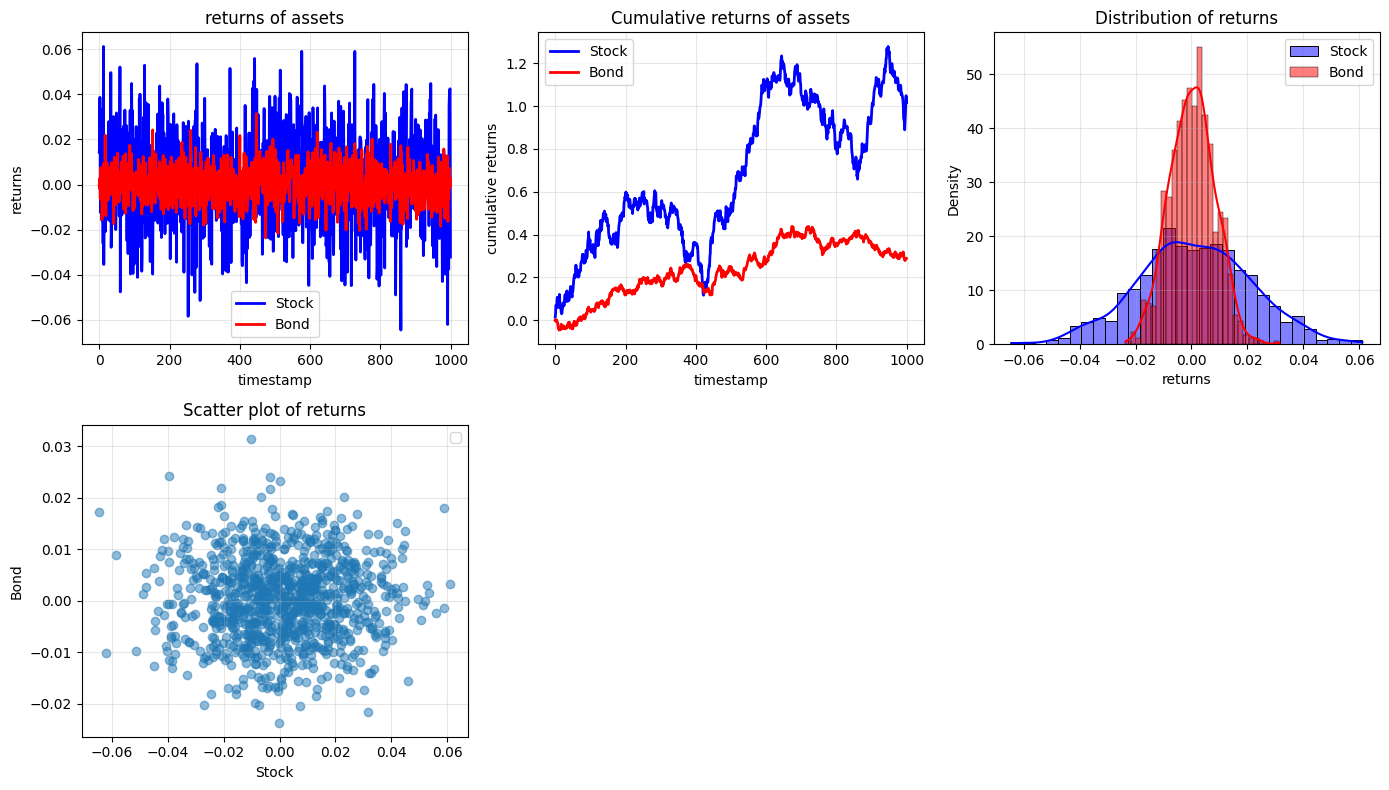

In [18]:
# Convergence de la médiane
asset_1 = returns_data[:, 0].tolist()
asset_2 = returns_data[:, 1].tolist()


plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plt.plot(asset_1, 'b-', linewidth=2, label=asset_names[0])
plt.plot(asset_2, 'r-', linewidth=2, label=asset_names[1])
plt.xlabel('timestamp')
plt.ylabel('returns')
plt.title('returns of assets')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(np.cumsum(asset_1), 'b-', linewidth=2, label=asset_names[0])
plt.plot(np.cumsum(asset_2), 'r-', linewidth=2, label=asset_names[1])
plt.xlabel('timestamp')
plt.ylabel('cumulative returns')
plt.title('Cumulative returns of assets')
plt.legend()
plt.grid(True, alpha=0.3)

# plot the distribution of returns
plt.subplot(2, 3, 3)
sns.histplot(asset_1, kde=True, color='blue', label=asset_names[0], stat='density', bins=30)
sns.histplot(asset_2, kde=True, color='red', label=asset_names[1], stat='density', bins=30)
plt.xlabel('returns')
plt.ylabel('Density')
plt.title('Distribution of returns')
plt.legend()
plt.grid(True, alpha=0.3)

# scatter plot of returns
plt.subplot(2, 3, 4)
plt.scatter(asset_1, asset_2, alpha=0.5)
plt.xlabel(asset_names[0])
plt.ylabel(asset_names[1])
plt.title('Scatter plot of returns')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Initialize and fit copula model
copula_model = MultivariateCopulaModel(df=2)

In [21]:
# Fit marginal distributions
marginals = copula_model.fit_marginals(returns_data, distribution='normal')
print(f"\n2. Fitted Marginal Distributions:")
for i, (dist_type, *params) in marginals.items():
    asset = asset_names[i]
    if dist_type == 'normal':
        print(f"{asset}: Normal(μ={params[0]:.6f}, σ={params[1]:.6f})")


2. Fitted Marginal Distributions:
Stock: Normal(μ=0.001017, σ=0.020161)
Bond: Normal(μ=0.000289, σ=0.008002)


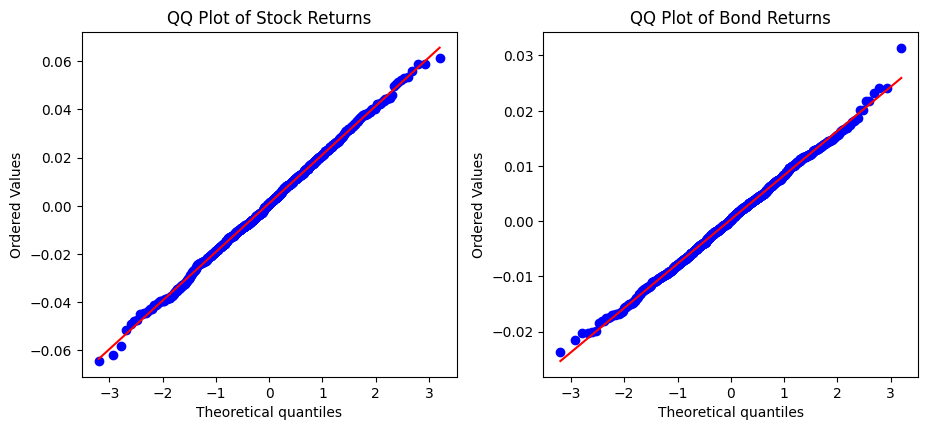

In [17]:
# ploter les qq plots pour valider l'hypothèse de normalité (suposée en caluclant les marginals)
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
stats.probplot(asset_1, dist="norm", plot=plt)
plt.title(f'QQ Plot of {asset_names[0]} Returns')
plt.subplot(2, 3, 2)
stats.probplot(asset_2, dist="norm", plot=plt)
plt.title(f'QQ Plot of {asset_names[1]} Returns')
plt.tight_layout()
plt.show()

In [11]:
# Transform to uniform and fit copula
uniform_data = copula_model.transform_to_uniform(returns_data)
uniform_data

array([[0.31620972, 0.40299027],
       [0.25207289, 0.91377567],
       [0.61171788, 0.39978585],
       ...,
       [0.36281532, 0.83030602],
       [0.5320956 , 0.18065652],
       [0.58701894, 0.2228319 ]], shape=(1000, 2))

/var/folders/kw/gf0t96sj4_d256ws4dzdlxc80000gn/T/ipykernel_4022/183916407.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


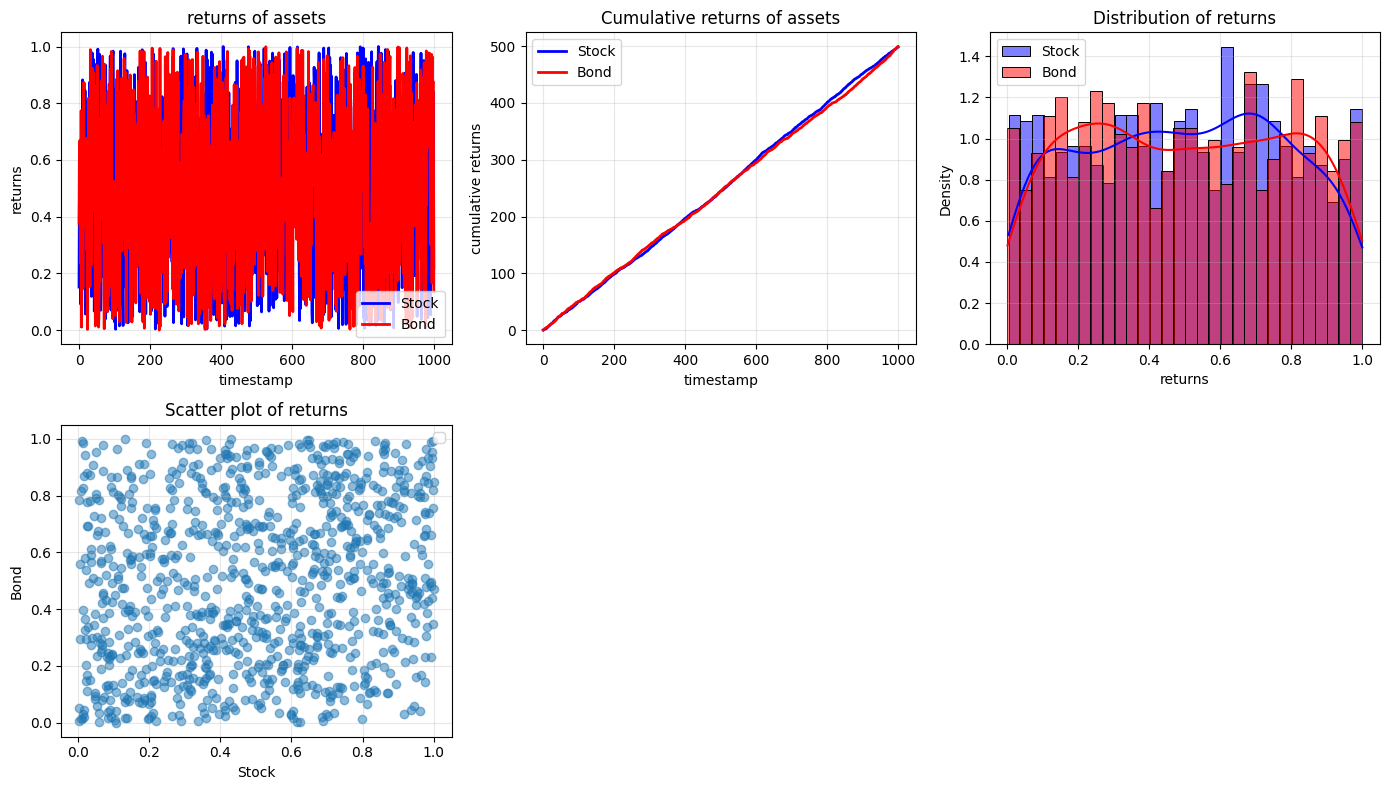

In [57]:
# Convergence de la médiane
uniform_asset_1 = uniform_data[:, 0].tolist()
uniform_asset_2 = uniform_data[:, 1].tolist()


plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plt.plot(uniform_asset_1, 'b-', linewidth=2, label=asset_names[0])
plt.plot(uniform_asset_2, 'r-', linewidth=2, label=asset_names[1])
plt.xlabel('timestamp')
plt.ylabel('returns')
plt.title('returns of assets')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(np.cumsum(uniform_asset_1), 'b-', linewidth=2, label=asset_names[0])
plt.plot(np.cumsum(uniform_asset_2), 'r-', linewidth=2, label=asset_names[1])
plt.xlabel('timestamp')
plt.ylabel('cumulative returns')
plt.title('Cumulative returns of assets')
plt.legend()
plt.grid(True, alpha=0.3)

# plot the distribution of returns
plt.subplot(2, 3, 3)
sns.histplot(uniform_asset_1, kde=True, color='blue', label=asset_names[0], stat='density', bins=30)
sns.histplot(uniform_asset_2, kde=True, color='red', label=asset_names[1], stat='density', bins=30)
plt.xlabel('returns')
plt.ylabel('Density')
plt.title('Distribution of returns')
plt.legend()
plt.grid(True, alpha=0.3)

# scatter plot of returns
plt.subplot(2, 3, 4)
plt.scatter(uniform_asset_1, uniform_asset_2, alpha=0.5)
plt.xlabel(asset_names[0])
plt.ylabel(asset_names[1])
plt.title('Scatter plot of returns')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [62]:
correlation_matrix = copula_model.fit_copula(uniform_data)
print(f"\n3. Copula Correlation Matrix (df={copula_model.df}):")
print(correlation_matrix)


3. Copula Correlation Matrix (df=2):
[[1.         0.03721453]
 [0.03721453 1.        ]]


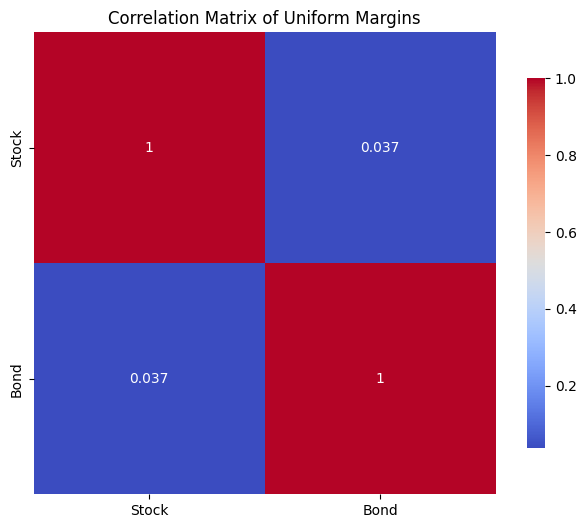

In [60]:
# plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8},
            xticklabels=asset_names, yticklabels=asset_names)
plt.title('Correlation Matrix of Uniform Margins')
plt.show()

In [69]:
# Generate simulations

# "Si l'action chute de -30%, que dit notre modèle 
# sur le comportement probable de l'obligation ?"
# → Extrapolation intelligente basée sur la structure de dépendance

n_simulations = 10000
simulated_data = copula_model.simulate(n_simulations, asset_names)

print(simulated_data.describe())
print(f"\nSimulated Correlation Matrix:")
print(simulated_data.corr())

print(f"\n4. Simulation Results ({n_simulations} samples):")
simulated_data


              Stock          Bond
count  10000.000000  10000.000000
mean       0.001204      0.000209
std        0.020496      0.007965
min       -0.074267     -0.031091
25%       -0.012505     -0.005135
50%        0.001162      0.000319
75%        0.014975      0.005698
max        0.074761      0.029083

Simulated Correlation Matrix:
          Stock      Bond
Stock  1.000000  0.008886
Bond   0.008886  1.000000

4. Simulation Results (10000 samples):


,Stock,Bond
0,0.025114,0.007677
1,-0.012427,-0.000151
2,0.021609,0.009581
3,-0.021778,-0.003565
4,-0.005994,0.001051
...,...,...
9995,0.002045,-0.007526
9996,-0.027998,0.010178
9997,0.001339,-0.006577
9998,0.006624,-0.002476


/var/folders/kw/gf0t96sj4_d256ws4dzdlxc80000gn/T/ipykernel_4022/4096894047.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


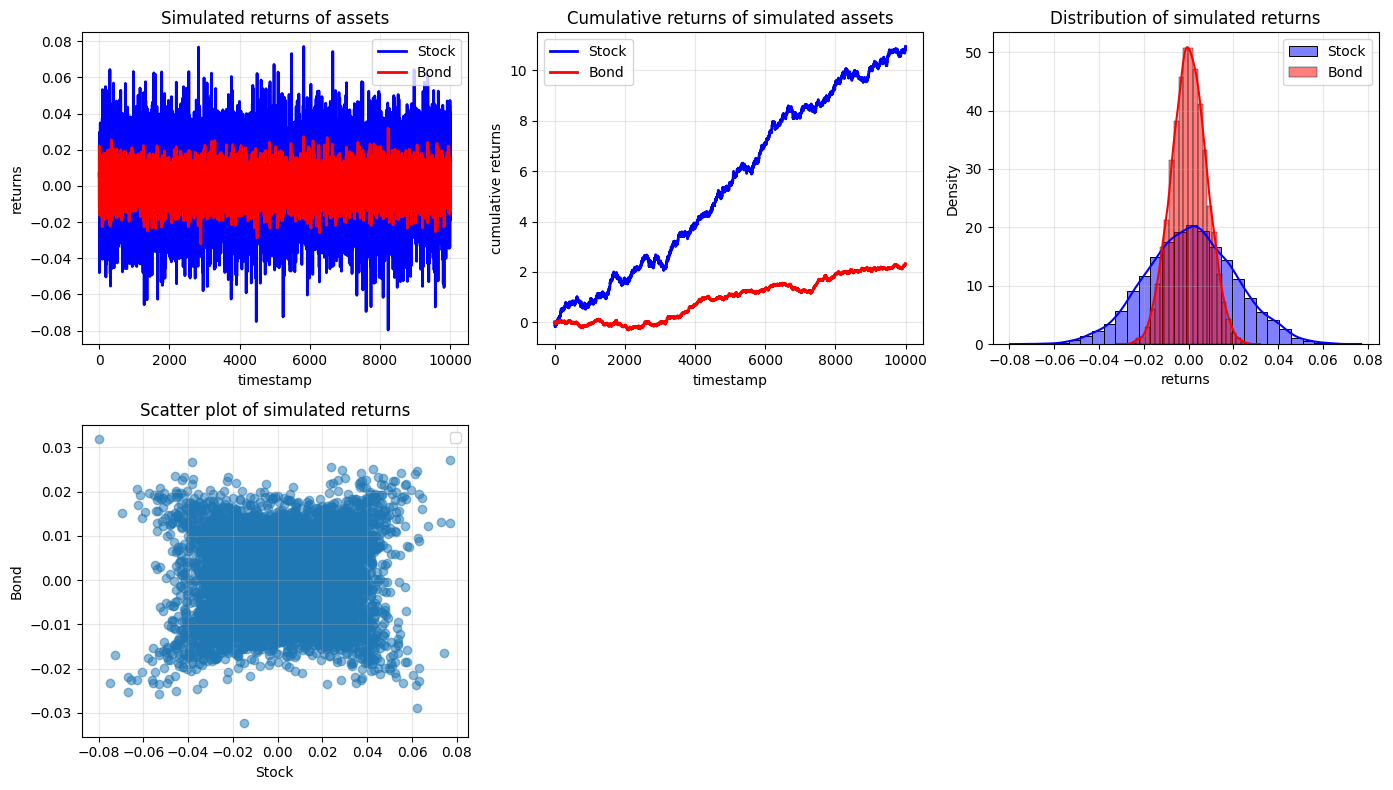

In [65]:
# Plot the simulated data
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plt.plot(simulated_data[asset_names[0]], 'b-', linewidth=2, label=asset_names[0])
plt.plot(simulated_data[asset_names[1]], 'r-', linewidth=2, label=asset_names[1])
plt.xlabel('timestamp')
plt.ylabel('returns')
plt.title('Simulated returns of assets')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(2, 3, 2)
plt.plot(np.cumsum(simulated_data[asset_names[0]]), 'b-', linewidth=2, label=asset_names[0])
plt.plot(np.cumsum(simulated_data[asset_names[1]]), 'r-', linewidth=2, label=asset_names[1])
plt.xlabel('timestamp')
plt.ylabel('cumulative returns')
plt.title('Cumulative returns of simulated assets')
plt.legend()
plt.grid(True, alpha=0.3)
# plot the distribution of simulated returns
plt.subplot(2, 3, 3)
sns.histplot(simulated_data[asset_names[0]], kde=True, color='blue', label=asset_names[0], stat='density', bins=30)
sns.histplot(simulated_data[asset_names[1]], kde=True, color='red', label=asset_names[1], stat='density', bins=30)
plt.xlabel('returns')
plt.ylabel('Density')
plt.title('Distribution of simulated returns')
plt.legend()
plt.grid(True, alpha=0.3)
# scatter plot of simulated returns
plt.subplot(2, 3, 4)
plt.scatter(simulated_data[asset_names[0]], simulated_data[asset_names[1]], alpha=0.5)
plt.xlabel(asset_names[0])
plt.ylabel(asset_names[1])
plt.title('Scatter plot of simulated returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [72]:
print(f"\n5. Risk Analysis:")
    
# Value at Risk (VaR) calculations
confidence_levels = [0.95, 0.99]
for cl in confidence_levels:
    var_stock = np.percentile(simulated_data['Stock'], (1-cl)*100)
    var_bond = np.percentile(simulated_data['Bond'], (1-cl)*100)
    
    # Portfolio VaR (equal weights)
    portfolio_returns = 0.5 * simulated_data['Stock'] + 0.5 * simulated_data['Bond']
    var_portfolio = np.percentile(portfolio_returns, (1-cl)*100)
    
    print(f"\n{cl*100}% VaR:")
    print(f"  Stock: {var_stock:.4f}")
    print(f"  Bond: {var_bond:.4f}")
    print(f"  Portfolio (50-50): {var_portfolio:.4f}")

# Expected Shortfall (ES) calculations
for cl in confidence_levels:
    es_stock = simulated_data['Stock'][simulated_data['Stock'] <= np.percentile(simulated_data['Stock'], (1-cl)*100)].mean()
    es_bond = simulated_data['Bond'][simulated_data['Bond'] <= np.percentile(simulated_data['Bond'], (1-cl)*100)].mean()
    
    # Portfolio ES (equal weights)
    portfolio_returns = 0.5 * simulated_data['Stock'] + 0.5 * simulated_data['Bond']
    es_portfolio = portfolio_returns[portfolio_returns <= np.percentile(portfolio_returns, (1-cl)*100)].mean()
    
    print(f"\n{cl*100}% Expected Shortfall:")
    print(f"  Stock: {es_stock:.4f}")
    print(f"  Bond: {es_bond:.4f}")
    print(f"  Portfolio (50-50): {es_portfolio:.4f}")


5. Risk Analysis:

95.0% VaR:
  Stock: -0.0325
  Bond: -0.0130
  Portfolio (50-50): -0.0173

99.0% VaR:
  Stock: -0.0464
  Bond: -0.0183
  Portfolio (50-50): -0.0263

95.0% Expected Shortfall:
  Stock: -0.0407
  Bond: -0.0164
  Portfolio (50-50): -0.0228

99.0% Expected Shortfall:
  Stock: -0.0527
  Bond: -0.0215
  Portfolio (50-50): -0.0315


In [78]:
# Tail dependence analysis
print(f"\n6. Tail Dependence Analysis:")
threshold = 0.05  # 5% worst cases

stock_extreme = simulated_data['Stock'] <= np.percentile(simulated_data['Stock'], threshold*100)
bond_extreme = simulated_data['Bond'] <= np.percentile(simulated_data['Bond'], threshold*100)

joint_extreme = stock_extreme & bond_extreme
joint_extreme


6. Tail Dependence Analysis:


0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool

In [79]:
# Calculate lower tail dependence
lower_tail_dep = np.sum(joint_extreme) / np.sum(stock_extreme)

print(f"Lower tail dependence (5% threshold): {lower_tail_dep:.4f}")
print(f"Joint extreme events: {np.sum(joint_extreme)} out of {n_simulations}")

Lower tail dependence (5% threshold): 0.1820
Joint extreme events: 91 out of 10000


In [10]:

# Visualization function
def create_visualizations(original_data, simulated_data):
    """Create comprehensive visualizations"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Original data scatter plot
    axes[0,0].scatter(original_data[:, 0], original_data[:, 1], alpha=0.6, s=20)
    axes[0,0].set_xlabel('Stock Returns')
    axes[0,0].set_ylabel('Bond Returns')
    axes[0,0].set_title('Original Data Scatter Plot')
    axes[0,0].grid(True, alpha=0.3)
    
    # Simulated data scatter plot
    axes[0,1].scatter(simulated_data['Stock'], simulated_data['Bond'], alpha=0.3, s=10)
    axes[0,1].set_xlabel('Stock Returns')
    axes[0,1].set_ylabel('Bond Returns')
    axes[0,1].set_title('Simulated Data Scatter Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # Distribution comparison - Stock
    axes[0,2].hist(original_data[:, 0], bins=50, alpha=0.7, label='Original', density=True)
    axes[0,2].hist(simulated_data['Stock'], bins=50, alpha=0.7, label='Simulated', density=True)
    axes[0,2].set_xlabel('Stock Returns')
    axes[0,2].set_ylabel('Density')
    axes[0,2].set_title('Stock Returns Distribution')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # Distribution comparison - Bond
    axes[1,0].hist(original_data[:, 1], bins=50, alpha=0.7, label='Original', density=True)
    axes[1,0].hist(simulated_data['Bond'], bins=50, alpha=0.7, label='Simulated', density=True)
    axes[1,0].set_xlabel('Bond Returns')
    axes[1,0].set_ylabel('Density')
    axes[1,0].set_title('Bond Returns Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Portfolio returns
    portfolio_original = 0.5 * original_data[:, 0] + 0.5 * original_data[:, 1]
    portfolio_simulated = 0.5 * simulated_data['Stock'] + 0.5 * simulated_data['Bond']
    
    axes[1,1].hist(portfolio_original, bins=50, alpha=0.7, label='Original', density=True)
    axes[1,1].hist(portfolio_simulated, bins=50, alpha=0.7, label='Simulated', density=True)
    axes[1,1].set_xlabel('Portfolio Returns (50-50)')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Portfolio Returns Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # Q-Q plot for model validation
    from scipy import stats
    stock_quantiles_orig = np.percentile(original_data[:, 0], np.linspace(1, 99, 99))
    stock_quantiles_sim = np.percentile(simulated_data['Stock'], np.linspace(1, 99, 99))
    
    axes[1,2].scatter(stock_quantiles_orig, stock_quantiles_sim, alpha=0.7)
    axes[1,2].plot([stock_quantiles_orig.min(), stock_quantiles_orig.max()], 
                   [stock_quantiles_orig.min(), stock_quantiles_orig.max()], 'r--')
    axes[1,2].set_xlabel('Original Data Quantiles')
    axes[1,2].set_ylabel('Simulated Data Quantiles')
    axes[1,2].set_title('Q-Q Plot: Stock Returns')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

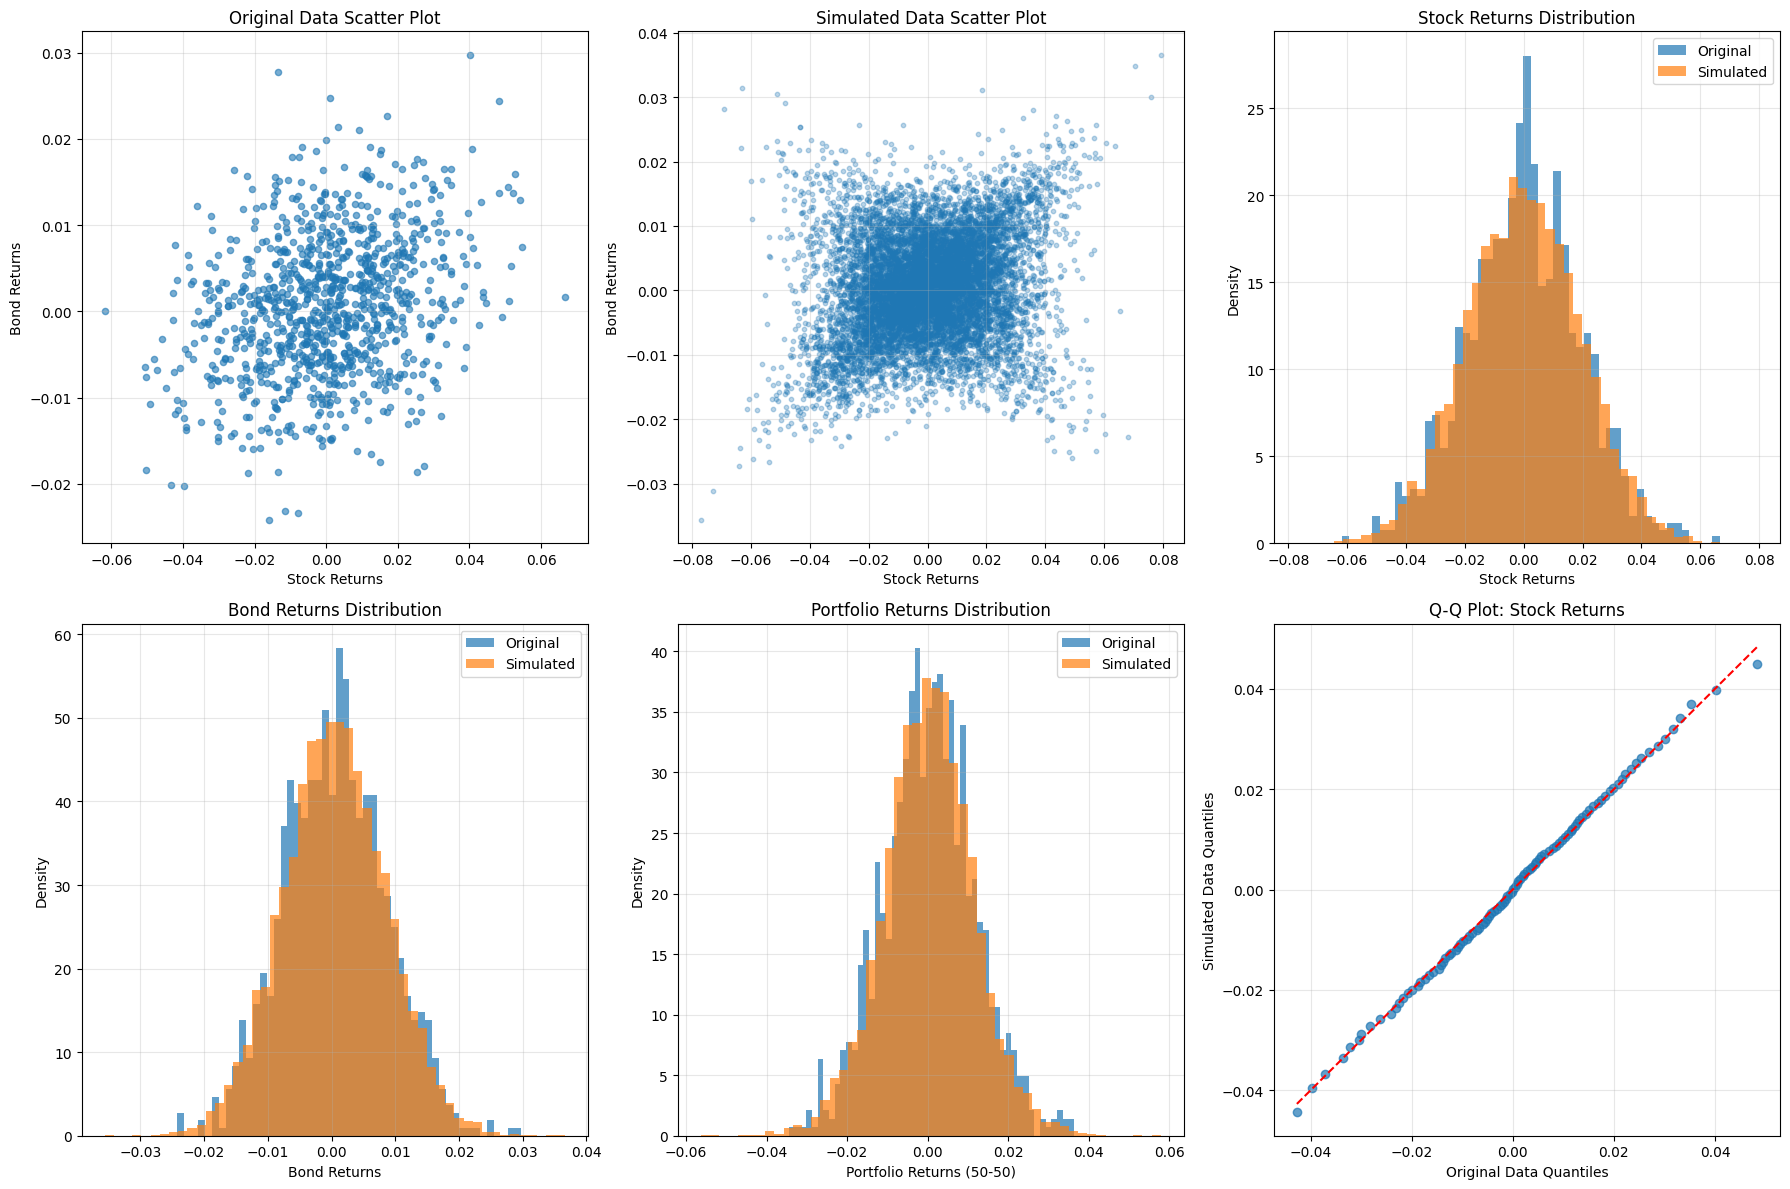

In [12]:
create_visualizations(original_data, simulated_data)